In [2]:
directory_path = r"D:\DataVKR\AnonymousStudy35\T2\Ax T2 FSE PROP 3MM anonymized"

In [3]:
import os
import numpy as np
import pydicom

def load_mri_dicom_slices(directory):
    """
    Загружает DICOM-файлы из указанной директории и преобразует их в numpy массив.

    Параметры:
        directory (str): Путь к директории с 32 слоями DICOM-файлов.

    Возвращает:
        numpy.ndarray: Массив размером (32, 512, 512).
    """
    files = sorted([f for f in os.listdir(directory) if f.startswith('IM')])
    
    if len(files) != 32:
        raise ValueError(f"Ожидается 32 файла, но найдено {len(files)}")
    
    slices = []
    for file in files:
        file_path = os.path.join(directory, file)
        
        try:
            dicom_data = pydicom.dcmread(file_path)
        except Exception as e:
            raise ValueError(f"Не удалось прочитать файл {file_path}: {e}")
        
        img_array = dicom_data.pixel_array
        
        if img_array.shape != (512, 512):
            raise ValueError(f"Файл {file} имеет некорректный размер {img_array.shape}, ожидается (512, 512)")
        
        slices.append(img_array)
    
    volume_array = np.stack(slices, axis=0)
    
    return volume_array

mri_volume = load_mri_dicom_slices(directory_path)
print(mri_volume.shape)  # Ожидается (32, 512, 512)




(32, 512, 512)


In [4]:
data = {"slice":"0-n", "array":list, "points":[[100, 200]], "roi":[100,200,300,100]}

In [5]:
import numpy as np

def normalize_to_grayscale(volume_array):
    """
    Нормализует 3D массив пикселей МРТ в диапазон [0, 255], чтобы представить в grayscale.

    Параметры:
        volume_array (numpy.ndarray): Массив размером (глубина, высота, ширина).

    Возвращает:
        numpy.ndarray: Нормализованный массив в grayscale с типом uint8.
    """
    min_val = np.min(volume_array)
    max_val = np.max(volume_array)
    normalized_volume = (volume_array - min_val) / (max_val - min_val)

    grayscale_volume = (normalized_volume * 255).astype(np.uint8)
    
    return grayscale_volume

grayscale_mri_volume = normalize_to_grayscale(mri_volume)
print(grayscale_mri_volume.shape)  # Ожидается (32, 512, 512)

(32, 512, 512)


KeyboardInterrupt: 

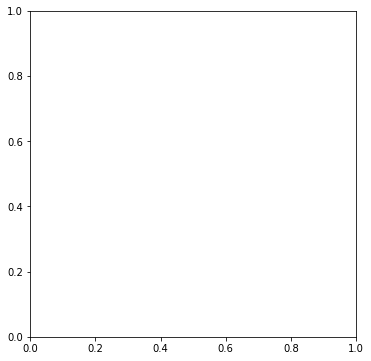

In [6]:
import matplotlib.pyplot as plt

def display_mri_slices(volume_array):
    """
    Отображает слои 3D массива МРТ.

    Параметры:
        volume_array (numpy.ndarray): 3D массив (глубина, высота, ширина).

    P.S. то что закоменчено выводит все слои 
    """
#     num_slices = volume_array.shape[0]  # Количество слоев
#     cols = 8  # Количество столбцов для отображения
#     rows = (num_slices + cols - 1) // cols  # Количество строк

#     fig, axes = plt.subplots(rows, cols, figsize=(16, 2 * rows))
#     axes = axes.flatten()

#     for i in range(len(axes)):
#         if i < num_slices:
#             axes[i].imshow(volume_array[i], cmap="gray")
#             axes[i].set_title(f"Slice {i + 1}")
#         axes[i].axis("off")

#     plt.tight_layout()
#     plt.show()

# # Пример использования
# display_mri_slices(grayscale_mri_volume)

    
    plt.figure(figsize=(6, 6))
    plt.imshow(volume_array[16], cmap="gray")
    plt.axis("off")
    plt.show()

# Пример использования
display_mri_slices(grayscale_mri_volume)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
def normalize_pixel_array(pixel_array):

    scaler = MinMaxScaler()
    # Меняем размерность массива пикселей для работы с MinMaxScaler
    reshaped_pixel_array = pixel_array.reshape(-1, 1)
    normalized_pixel_array = scaler.fit_transform(reshaped_pixel_array)
    # Возвращаем нормализованный массив в исходную форму
    normalized_pixel_array = normalized_pixel_array.reshape(pixel_array.shape)

    # Создайте каналы R, G и B, взяв значения из нормализованного массива
    R_channel = normalized_pixel_array  # Красный канал
    G_channel = normalized_pixel_array  # Зеленый канал (полностью нулевой массив)
    B_channel = normalized_pixel_array  # Синий канал (полностью нулевой массив)

    # Сформируйте массив RGB из трех каналов
    rgb_image = np.stack([R_channel, G_channel, B_channel], axis=-1)

    # Масштабируйте значения обратно к диапазону [0, 255]
    rgb_image = (rgb_image * 255).astype(np.uint8)
    #print(points, roi, rgb_image)
    return rgb_image

img = normalize_pixel_array(grayscale_mri_volume)
img[16,:,:,:]

(512, 512, 3)

In [10]:
from segment_anything import sam_model_registry, SamPredictor
import numpy as np
"""работает около минуты"""
# Настройки модели
model_type = "vit_h"
sam_checkpoint = "sam_vit_h_4b8939.pth"

# Загрузка модели
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.eval()


# # Настройка предсказателя
# predictor = SamPredictor(sam)

# # Установка изображения в SAM
# predictor.set_image(img[16,:,:,:])

# print("Изображение успешно установлено в SAM!")


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [14]:
import
analytics = Analytics(analytics_type="line")
frame = cv2.imread("image.jpg")
processed_frame = analytics.process_data(frame, frame_number=1)
cv2.imshow("Analytics", processed_frame)

<generator object Module.parameters at 0x000002C8E07A7AE0>


<bound method Module.modules of Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

In [46]:
points = [[263, 145]]
input_label = [1]




In [52]:
def mask_array_all(points, input_label, predictor) -> np.array:  # расчитано на то что есть и roi и points
    input_point = points
    input_point = [list(map(round, inner_list)) for inner_list in input_point]
    # roi = list(map(int, [item for sublist in roi for item in sublist]))

    print(f"points {input_point, type(input_point)}")
    if len(input_point) > 0:
        mask_points, scores, logits = predictor.predict(
            point_coords=np.array(input_point),
            point_labels=input_label,
            multimask_output=False,  # если тут true, то выдает 3 маски
        )
        count_true = np.count_nonzero(mask_points)
    else:
        mask_points = np.array([])

    return mask_points

mask = mask_array_all(points=points, input_label=input_label, predictor=predictor)

points ([[263, 145]], <class 'list'>)


In [48]:
count_true = np.count_nonzero(mask)
count_true

12114

In [38]:
512*512

262144

In [49]:
from PIL import Image
import numpy as np

def save_mask_as_image(mask, output_path="mask.png"):
    """
    Сохраняет бинарный массив как изображение.

    Параметры:
        mask (numpy.ndarray): Бинарный массив размером (1, H, W) или (H, W).
        output_path (str): Путь для сохранения изображения.
    """
    if mask.ndim == 3 and mask.shape[0] == 1:
        mask = mask[0]  # Преобразуем (1, H, W) в (H, W)

    # Масштабируем маску в диапазон [0, 255]
    mask_image = (mask * 255).astype(np.uint8)

    # Создаем изображение и сохраняем
    img = Image.fromarray(mask_image)
    img.save(output_path)
    print(f"Маска сохранена как {output_path}")

save_mask_as_image(mask, "binary_mask.png")


Маска сохранена как binary_mask.png


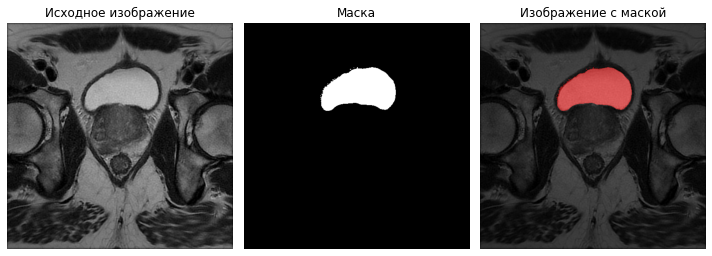

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def overlay_mask(image, mask, mask_color=(255, 0, 0), alpha=0.5):
    """
    Накладывает бинарную маску на изображение.

    Параметры:
        image (numpy.ndarray): Изображение размером (512, 512, 3).
        mask (numpy.ndarray): Бинарная маска размером (1, 512, 512) или (512, 512).
        mask_color (tuple): Цвет маски в формате RGB (по умолчанию красный).
        alpha (float): Прозрачность маски (от 0 до 1).

    Возвращает:
        numpy.ndarray: Изображение с наложенной маской.
    """
    if mask.ndim == 3 and mask.shape[0] == 1:
        mask = mask[0]  # Преобразуем (1, 512, 512) в (512, 512)

    # Создаем копию исходного изображения
    overlayed_image = image.copy()

    # Преобразуем цвет маски в 3D массив размером (512, 512, 3)
    mask_rgb = np.zeros_like(image, dtype=np.uint8)
    mask_rgb[mask > 0] = mask_color

    # Накладываем маску с прозрачностью
    overlayed_image = np.clip(
        (1 - alpha) * overlayed_image + alpha * mask_rgb, 0, 255
    ).astype(np.uint8)

    return overlayed_image


result = overlay_mask(img[16,:,:,:], mask)

# Визуализация
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img[16,:,:,:])
plt.title("Исходное изображение")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask[0], cmap="gray")
plt.title("Маска")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(result)
plt.title("Изображение с маской")
plt.axis("off")

plt.tight_layout()
plt.show()


# Тесты на мозге

In [54]:
import cv2
import numpy as np

gray_image = cv2.imread('brain.jpg', cv2.IMREAD_GRAYSCALE)
gray_array = np.array(gray_image)
print(gray_array)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
gray_array.shape = (1, 630, 630)
brain_point = [[242,392]]

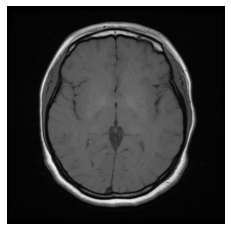

In [61]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(gray_array[0, :, :], cmap='gray')  # []
plt.axis('off')  
plt.show()  


In [67]:
normalized_gray_array = normalize_pixel_array(gray_array)
normalized_gray_array.shape

(1, 630, 630, 3)

In [68]:
from segment_anything import sam_model_registry, SamPredictor
import numpy as np
"""работает около минуты"""

model_type = "vit_h"
sam_checkpoint = "sam_vit_h_4b8939.pth"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.eval()

predictor = SamPredictor(sam)

predictor.set_image(normalized_gray_array[0,:,:,:])

print("Изображение успешно установлено в SAM!")

Изображение успешно установлено в SAM!


In [69]:
def mask_array_all(points, input_label, predictor):  # расчитано на то что есть и roi и points
    input_point = points
    input_point = [list(map(round, inner_list)) for inner_list in input_point]
    # roi = list(map(int, [item for sublist in roi for item in sublist]))

    print(f"points {input_point, type(input_point)}")
    if len(input_point) > 0:
        mask_points, scores, logits = predictor.predict(
            point_coords=np.array(input_point),
            point_labels=input_label,
            multimask_output=False,  # если тут true, то выдает 3 маски
        )
        count_true = np.count_nonzero(mask_points)
    else:
        mask_points = np.array([])

    return mask_points

mask = mask_array_all(points=[[242,392]], input_label=[1], predictor=predictor)


points ([[242, 392]], <class 'list'>)


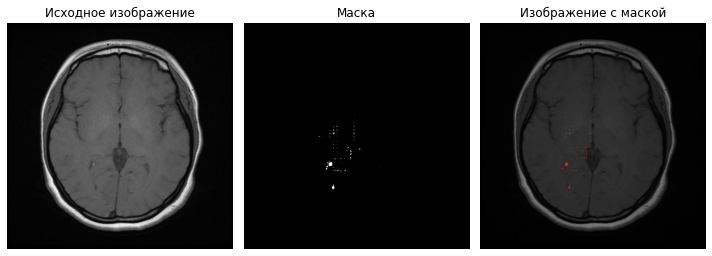

In [70]:
import numpy as np
import matplotlib.pyplot as plt

def overlay_mask(image, mask, mask_color=(255, 0, 0), alpha=0.5):
    """
    Накладывает бинарную маску на изображение.

    Параметры:
        image (numpy.ndarray): Изображение размером (512, 512, 3).
        mask (numpy.ndarray): Бинарная маска размером (1, 512, 512) или (512, 512).
        mask_color (tuple): Цвет маски в формате RGB (по умолчанию красный).
        alpha (float): Прозрачность маски (от 0 до 1).

    Возвращает:
        numpy.ndarray: Изображение с наложенной маской.
    """
    if mask.ndim == 3 and mask.shape[0] == 1:
        mask = mask[0]  # Преобразуем (1, 512, 512) в (512, 512)

    # Создаем копию исходного изображения
    overlayed_image = image.copy()

    # Преобразуем цвет маски в 3D массив размером (512, 512, 3)
    mask_rgb = np.zeros_like(image, dtype=np.uint8)
    mask_rgb[mask > 0] = mask_color

    # Накладываем маску с прозрачностью
    overlayed_image = np.clip(
        (1 - alpha) * overlayed_image + alpha * mask_rgb, 0, 255
    ).astype(np.uint8)

    return overlayed_image


result = overlay_mask(normalized_gray_array[0,:,:,:], mask)

# Визуализация
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(normalized_gray_array[0,:,:,:])
plt.title("Исходное изображение")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask[0], cmap="gray")
plt.title("Маска")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(result)
plt.title("Изображение с маской")
plt.axis("off")

plt.tight_layout()
plt.show()


# Тесты с запросами


In [23]:
import os
import numpy as np
import pydicom
import requests

def load_mri_dicom_slices(directory):
    """
    Загружает DICOM-файлы из указанной директории и преобразует их в numpy массив.

    Параметры:
        directory (str): Путь к директории с 32 слоями DICOM-файлов.

    Возвращает:
        numpy.ndarray: Массив размером (32, 512, 512).
    """
    files = sorted([f for f in os.listdir(directory) if f.startswith('IM')])
    
    if len(files) != 32:
        raise ValueError(f"Ожидается 32 файла, но найдено {len(files)}")
    
    slices = []
    for file in files:
        file_path = os.path.join(directory, file)
        
        try:
            dicom_data = pydicom.dcmread(file_path)
        except Exception as e:
            raise ValueError(f"Не удалось прочитать файл {file_path}: {e}")
        
        img_array = dicom_data.pixel_array
        
        if img_array.shape != (512, 512):
            raise ValueError(f"Файл {file} имеет некорректный размер {img_array.shape}, ожидается (512, 512)")
        
        slices.append(img_array)
    
    volume_array = np.stack(slices, axis=0)
    
    return volume_array
directory_path = r"D:\DataVKR\AnonymousStudy35\T2\Ax T2 FSE PROP 3MM anonymized"
mri_volume = load_mri_dicom_slices(directory_path)
print(mri_volume.shape)  # Ожидается (32, 512, 512)
arr = mri_volume[16,:,:].tolist()


json_test = {
    "points":  [[263, 145]],
    "pixel_arr": arr,
}


requests.post("http://localhost:5000/masks/points", json=json_test).json()


from PIL import Image
import numpy as np

# def save_mask_as_image(mask, output_path="mask.png"):
#     """
#     Сохраняет бинарный массив как изображение.

#     Параметры:
#         mask (numpy.ndarray): Бинарный массив размером (1, H, W) или (H, W).
#         output_path (str): Путь для сохранения изображения.
#     """
#     if mask.ndim == 3 and mask.shape[0] == 1:
#         mask = mask[0]  # Преобразуем (1, H, W) в (H, W)

#     # Масштабируем маску в диапазон [0, 255]
#     mask_image = (mask * 255).astype(np.uint8)

#     # Создаем изображение и сохраняем
#     img = Image.fromarray(mask_image)
#     img.save(output_path)
#     print(f"Маска сохранена как {output_path}")

# save_mask_as_image(mask, "binary_mask.png")


(32, 512, 512)


In [18]:
print(arr)

[[1311, 1371, 1415, 1429, 1431, 1451, 1487, 1502, 1479, 1456, 1468, 1495, 1508, 1517, 1533, 1527, 1479, 1444, 1467, 1497, 1467, 1410, 1419, 1502, 1560, 1523, 1470, 1475, 1523, 1552, 1530, 1474, 1427, 1414, 1413, 1408, 1418, 1466, 1527, 1550, 1518, 1471, 1445, 1444, 1461, 1490, 1515, 1510, 1468, 1413, 1386, 1404, 1451, 1497, 1521, 1529, 1529, 1515, 1483, 1442, 1410, 1400, 1404, 1404, 1389, 1367, 1368, 1404, 1450, 1472, 1459, 1435, 1427, 1433, 1434, 1429, 1428, 1437, 1446, 1448, 1446, 1445, 1442, 1430, 1409, 1389, 1377, 1377, 1393, 1421, 1440, 1429, 1399, 1389, 1414, 1438, 1425, 1394, 1394, 1415, 1408, 1358, 1314, 1331, 1404, 1460, 1442, 1369, 1302, 1282, 1293, 1295, 1282, 1293, 1333, 1371, 1383, 1377, 1361, 1320, 1250, 1198, 1199, 1227, 1233, 1205, 1171, 1144, 1116, 1090, 1084, 1098, 1103, 1080, 1042, 1030, 1064, 1125, 1168, 1194, 1237, 1310, 1369, 1365, 1313, 1290, 1316, 1344, 1347, 1353, 1388, 1421, 1406, 1362, 1350, 1372, 1383, 1360, 1334, 1332, 1343, 1337, 1328, 1343, 1381, 1416, 14

In [26]:
pwd

'c:\\Users\\mnfom\\Documents\\Finance1\\vkr\\Slicer_Project'

PRO TIP  Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


image 1/1 c:\Users\mnfom\Documents\Finance1\vkr\Slicer_Project\brain.jpg: 640x640 1 cake, 253.0ms
Speed: 7.0ms preprocess, 253.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


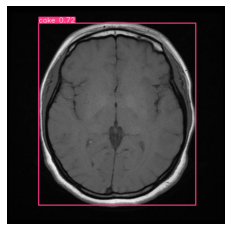

[ultralytics.yolo.engine.results.Results object with attributes:

boxes: ultralytics.yolo.engine.results.Boxes object
keypoints: None
keys: ['boxes']
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: '

In [8]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Загрузка предобученной модели YOLOv5
model = YOLO('yolov5s.pt')  # Вы можете выбрать другую модель, например, yolov5m.pt, yolov5l.pt и т.д.

# Выполнение инференса на изображении
results = model.predict(source='brain.jpg', conf=0.25)  # Укажите путь к вашему изображению

# Визуализация результатов
for result in results:
    # Получаем изображение с аннотациями
    annotated_image = result.plot()

    # Отображаем изображение
    plt.imshow(annotated_image)
    plt.axis('off')  # Отключаем оси
    plt.show()

# Сохранение результатов
print(results)  # Сохраняет аннотированные изображения в папку runs/detect/exp
